## Predicting Graduate Admissions using Deep Learning

We use tha Kaggle dataset: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions\
We construct a Neural Networks that predicts the probability of getting admitted.\

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

2023-07-28 17:52:25.943356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 17:52:26.071138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 17:52:26.072234: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 17:52:27.529090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = pd.read_csv('data/admissions_data.csv')
data.head(10)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
5,6,330,115,5,4.5,3.0,9.34,1,0.90
6,7,321,109,3,3.0,4.0,8.20,1,0.75
7,8,308,101,2,3.0,4.0,7.90,0,0.68
8,9,302,102,1,2.0,1.5,8.00,0,0.50
9,10,323,108,3,3.5,3.0,8.60,0,0.45


In [3]:
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [4]:
features = data.drop(columns=['Chance of Admit '])
labels = data.iloc[:,-1] # Choose the final column for prediction

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=32)

# Scale the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [5]:
# Design the model
model = Sequential()
# Add the input layer
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
# Add a hidden layer
model.add(layers.Dense(16, activation='relu'))
# Add the output layer
model.add(layers.Dense(1))
# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mse', metrics='mae', optimizer=opt)

# Train the model
hist = model.fit(X_train, Y_train, epochs=200, batch_size=20, validation_split=0.2, verbose=0) 

/home/alexis/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1700: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


In [7]:
# Evaluate the model
#loss, acc = model.evaluate(X_test, Y_test, verbose=1)
#print('Loss', loss, 'Accuracy', acc)
loss = model.evaluate(X_test, Y_test, verbose=1)
print('Loss:', loss)

5/5 [==============================] - 0s 3ms/step - loss: 0.0054 - mae: 0.0562
Loss: [0.005420896224677563, 0.05622144043445587]


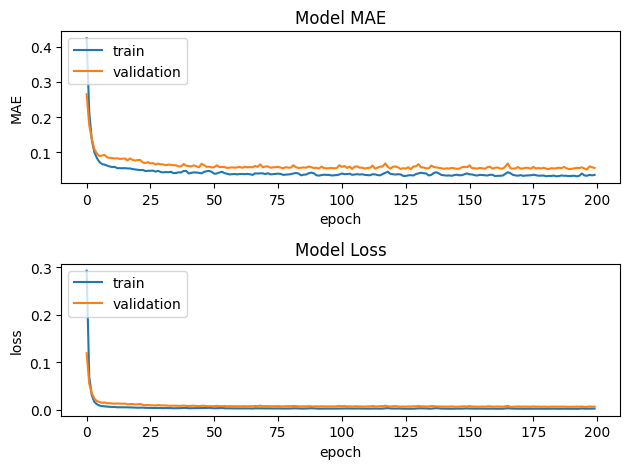

In [8]:
# Plot MSE as a function of epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(hist.history['mae'])
ax1.plot(hist.history['val_mae'])
ax1.set_title('Model MAE')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
 
# Plot loss and val_loss as a function of epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(hist.history['loss'])
ax2.plot(hist.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
 
# We save the plot as a png file 
fig.tight_layout()
fig.savefig('plot_results.png')

**R-squared error**

R-squared or Coefficient of Determination is a way to evaluate a regression model.\
The residual sum of squares is given by
$$ SS_{\rm res} = \sum_i (y_i-f_i)^2$$
while the total sum of squares is
$$ SS_{\rm res} = \sum_i (y_i-\bar{y}_i)^2$$


The $R^2$ coefficient is defined by:
$$ R^2 = 1 - \frac{SS_{\rm res}}{SS_{\rm tot}} $$

Therefore, if $R^2=1$ is a perfect model.\
If the prediction is always close to the mean $\bar{y}$, the model is not so good and $R^2=0$.\
If $R^2<0$ then it is a poor model with large errors.

In [9]:
# R^2 score
predicted_values = model.predict(X_test) 
print(r2_score(Y_test, predicted_values)) 

5/5 [==============================] - 0s 3ms/step
0.7815930240760678


In [10]:
X_test

,0,1,2,3,4,5,6,7
0,-1.545791,-1.725082,-1.553206,-1.023585,-1.967423,-1.077375,-1.957040,0.896729
1,0.572918,-0.153705,-0.564503,-0.125703,-0.418852,-1.077375,-0.488830,-1.115164
2,-0.368731,0.493333,1.083337,1.670060,1.129720,0.529505,0.590215,0.896729
3,0.622854,-0.523440,-0.399719,-1.023585,-0.418852,-1.613002,-0.860305,0.896729
4,-0.511405,0.493333,0.424201,0.772178,0.613529,1.600759,0.926311,0.896729
...,...,...,...,...,...,...,...,...
145,-1.517256,0.955503,-0.729287,-0.125703,0.613529,0.529505,-0.541898,0.896729
146,0.615720,0.955503,0.918553,-0.125703,0.097339,-0.541748,0.094916,0.896729
147,1.764246,-1.817516,-1.388422,0.772178,-0.418852,-0.006121,-1.408673,-1.115164
148,0.508714,-0.800742,-0.564503,-1.023585,-0.935042,-0.541748,-0.948751,-1.115164
